In [7]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip

In [2]:
plt.style.use('seaborn-whitegrid')

textwidth = 5.9

#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times New Roman"
import matplotlib.colors as colors

In [162]:
save_path = 'save_path'

#choose filepath to desired data
path = 'calibration_data_path'

# Import Calibration Data

Import hdf5 data generated from applying the pre-processing-Acktar notebook to the polarization calibration data

In [43]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    waves = file['/waves'][()]
    angles = file['/angles'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    
    E1 = file['responses_err1'][()]
    E2 = file['responses_err2'][()]


In [8]:
ri = riip.RiiDataFrame()

In [11]:
cdse_thickness = 5.01
lambda_min = 7;
lambda_max = 12.5;

CdSe_o = ri.material({'id': 662})
CdSe_e = ri.material({'id': 663})

Te_o = ri.material({'id': 747})
Te_e = ri.material({'id': 748})


birefringence = interp1d(waves, CdSe_e.n(waves)-CdSe_o.n(waves), kind='cubic')


Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.


In [12]:
def retardance(wavelength):
    d = float(birefringence(wavelength))
    return(cdse_thickness*d*1000)

## Determine Spectral Windows 

$\Delta\lambda$ is the maximum size of the window that can be used to demodulate as a function of center wavelength $\lambda_c$

In [13]:
def delta_lambda(lambda_c):
    delta = retardance(lambda_c)
    return(lambda_c**2/(delta*(1 +(lambda_c**2 / (4*delta**2)))))

def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx


Now, determine the spectral windows for demodulaation, returning the wavelength windows and the pixel numbers

In [14]:
lambda_c = []
lambda1  = []
lambda2  = []
pixel_c = []
pixel1  = []
pixel2  = [] 
for l in waves:
    size = delta_lambda(l)
    low  = l-size/2
    high = l+size/2
    if low > lambda_min and high < lambda_max:
        lambda_c.append(l)
        lambda1.append(low)
        lambda2.append(high)
        
        pixel_c.append(find_nearest(waves,l))
        pixel1.append(find_nearest(waves,low))
        pixel2.append(find_nearest(waves,high))

In [178]:
hf = h5py.File(save_path + 'calibration.h5', 'w')
g = hf.create_group('pixel')
g.create_dataset('wavelength',data= lambda_c)
g.create_dataset('pixel1',data=pixel1)
g.create_dataset('pixel2',data=pixel2)
hf.close()

## Calculate AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [16]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [17]:
t_unpol = np.mean(R1,axis = 0)/np.mean(R2,axis = 0)

transmission_aolp = np.zeros([len(angles),len(pixel_c)])
for a in range(len(angles)):
    I1 = R1[a]
    I2 = R2[a]
    for i in range(len(pixel_c)):
        v = transmission_correction(I1[pixel1[i]:pixel2[i]],I2[pixel1[i]:pixel2[i]],3)
        transmission_aolp[a,i] = v

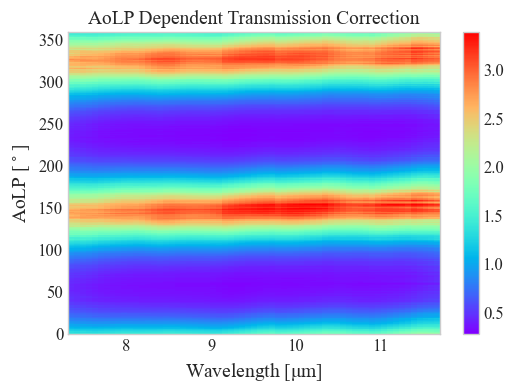

In [18]:
plt.pcolormesh(lambda_c,angles,transmission_aolp,shading='auto',cmap = 'rainbow')
plt.colorbar()
plt.gcf().set_dpi(100)
plt.title("AoLP Dependent Transmission Correction",fontsize = 14)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()

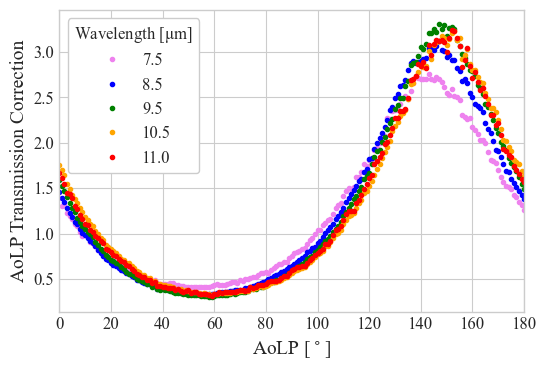

In [19]:
fig = fig = plt.gcf() 
plt.plot(angles,transmission_aolp[:,2],'.',color = 'violet',label = str(round(lambda_c[2],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,17],'.',color = 'blue',label = str(round(lambda_c[17],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,31],'.',color = 'green',label = str(round(lambda_c[31],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,45],'.',color = 'orange',label = str(round(lambda_c[45],1)),alpha = 1)
plt.plot(angles,transmission_aolp[:,52],'.',color = 'red',label = str(round(lambda_c[52],1)),alpha = 1)

plt.ylabel("AoLP Transmission Correction",fontsize = 14)
plt.xlabel('AoLP [$^\circ$]')

plt.xlim(0,180)
plt.gcf().set_dpi(100)
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')

In [179]:
hf = h5py.File(save_path + 'calibration.h5', 'a')
g = hf.create_group('transmission')
g.create_dataset('t_unpol',data= t_unpol)
g.create_dataset('t_pol', data=transmission_aolp)
g.create_dataset('angles',data=angles)
hf.close()

In [57]:
#error propagation
def mod_uncertainty(x,y,sigma_x,sigma_y):
    dm_mI = (4*x**2)/(x+y)**4
    return (dm_mI*(sigma_x**2 + sigma_y**2))**0.5
    

In [58]:
#calculate modulation function for calibration data
calibration_mod = np.zeros([len(angles),len(pixel_c)])
calibration_I1  = np.zeros([len(angles),len(pixel_c)])
calibration_I2  = np.zeros([len(angles),len(pixel_c)])
calibration_modE  = np.zeros([len(angles),len(pixel_c)])

for a in range(len(angles)):
    I1 = R1[a,pixel_c[0]:pixel_c[-1]+1]/t_unpol[pixel_c[0]:pixel_c[-1]+1]
    I2 = R2[a,pixel_c[0]:pixel_c[-1]+1]*transmission_aolp[a]
    e1 = E1[a,pixel_c[0]:pixel_c[-1]+1]
    e2 = E2[a,pixel_c[0]:pixel_c[-1]+1]

    mod_a = (I1-I2)/(I1+I2)
    mod_e = mod_uncertainty(I1,I2,e1,e2)
                            
    calibration_I1[a]  = I1
    calibration_I2[a]  = I2
    calibration_mod[a] = mod_a
    calibration_modE[a] = mod_e




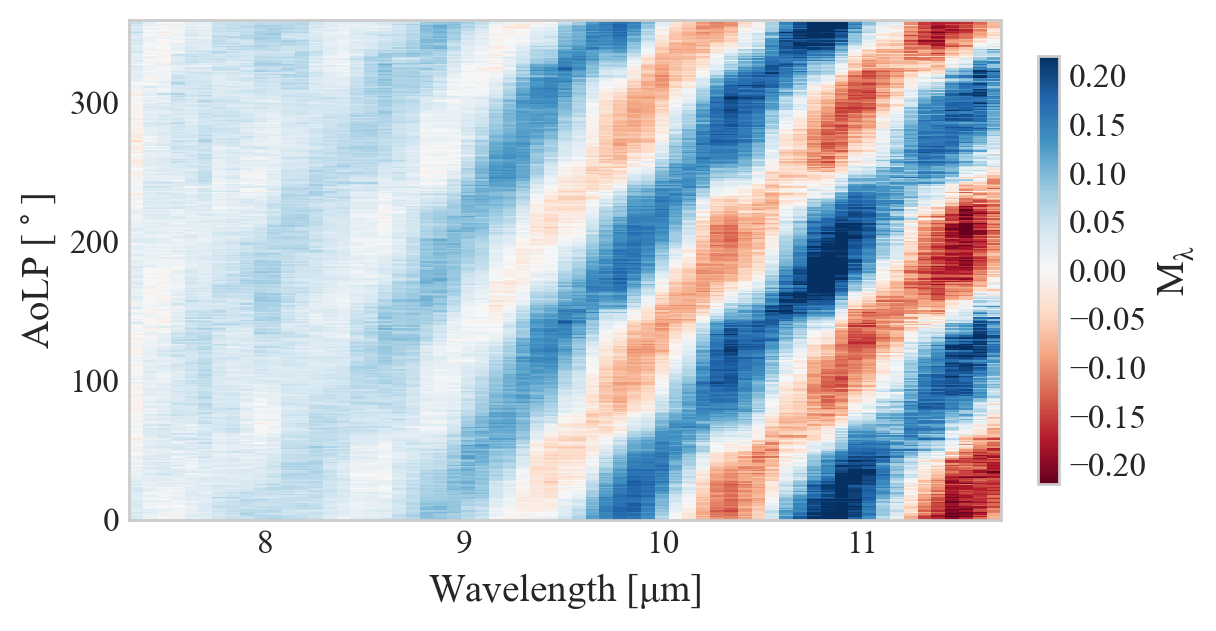

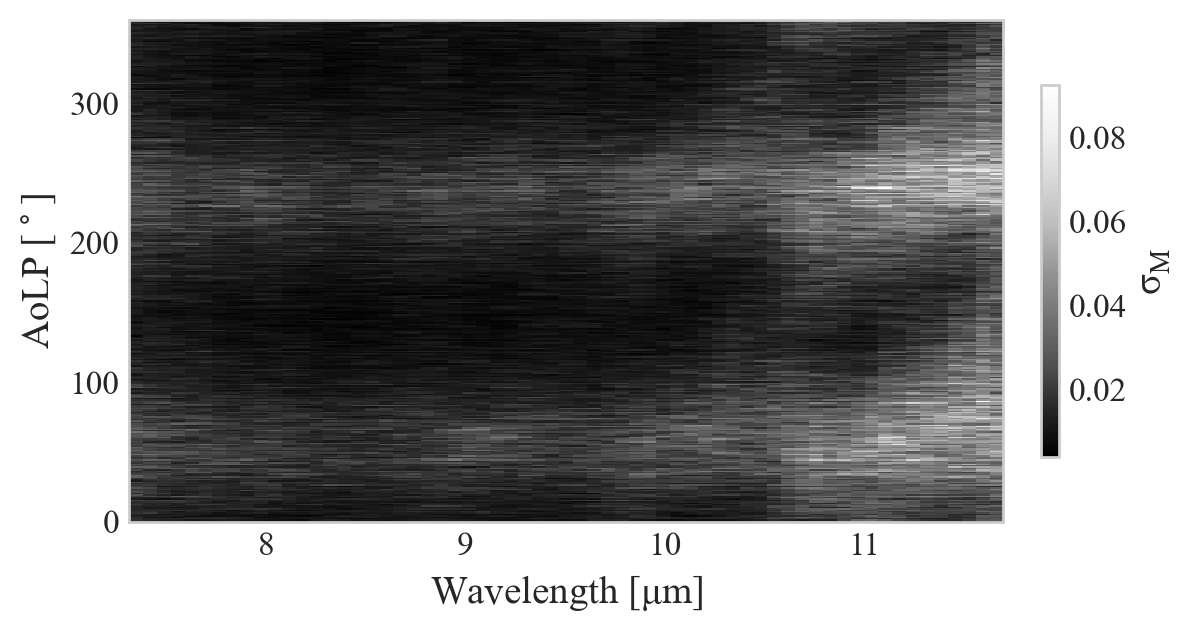

In [72]:
fig =plt.gcf()
plt.gca().set_aspect(.007)
plt.pcolormesh(lambda_c,angles,calibration_mod,shading='auto',norm=colors.PowerNorm(gamma=1,vmin = -.22,vmax = .22),cmap = 'RdBu')
plt.colorbar(label = "$\mathdefault{M_\lambda}$",fraction=0.023, pad=0.04)
plt.gcf().set_dpi(200)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()

fig =plt.gcf()
plt.gca().set_aspect(.007)
plt.pcolormesh(lambda_c,angles,calibration_modE,shading='auto',cmap = 'Greys_r')
plt.colorbar(label = "$\mathdefault{\sigma_M}$",fraction=0.02, pad=0.04)
plt.gcf().set_dpi(200)
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.ylabel('AoLP [$^\circ$]')
plt.show()


# Demodulation in Fourier Space

## periodogram

In [61]:
from astropy.timeseries import LombScargle

Calculate expected retardance in wavenumber space using refractive index data

In [76]:
wav=list(map(lambda l :1/(l*1.0e-4),lambda_c))
wavnums=list(map(lambda l :1/(l*1.0e-4),waves))
ret=list(map(lambda l :(retardance(l)/l)*1.0e-3,lambda_c))

Below is an example LS model 

expected retardance 0.0105509491023926
0.010094038002237751


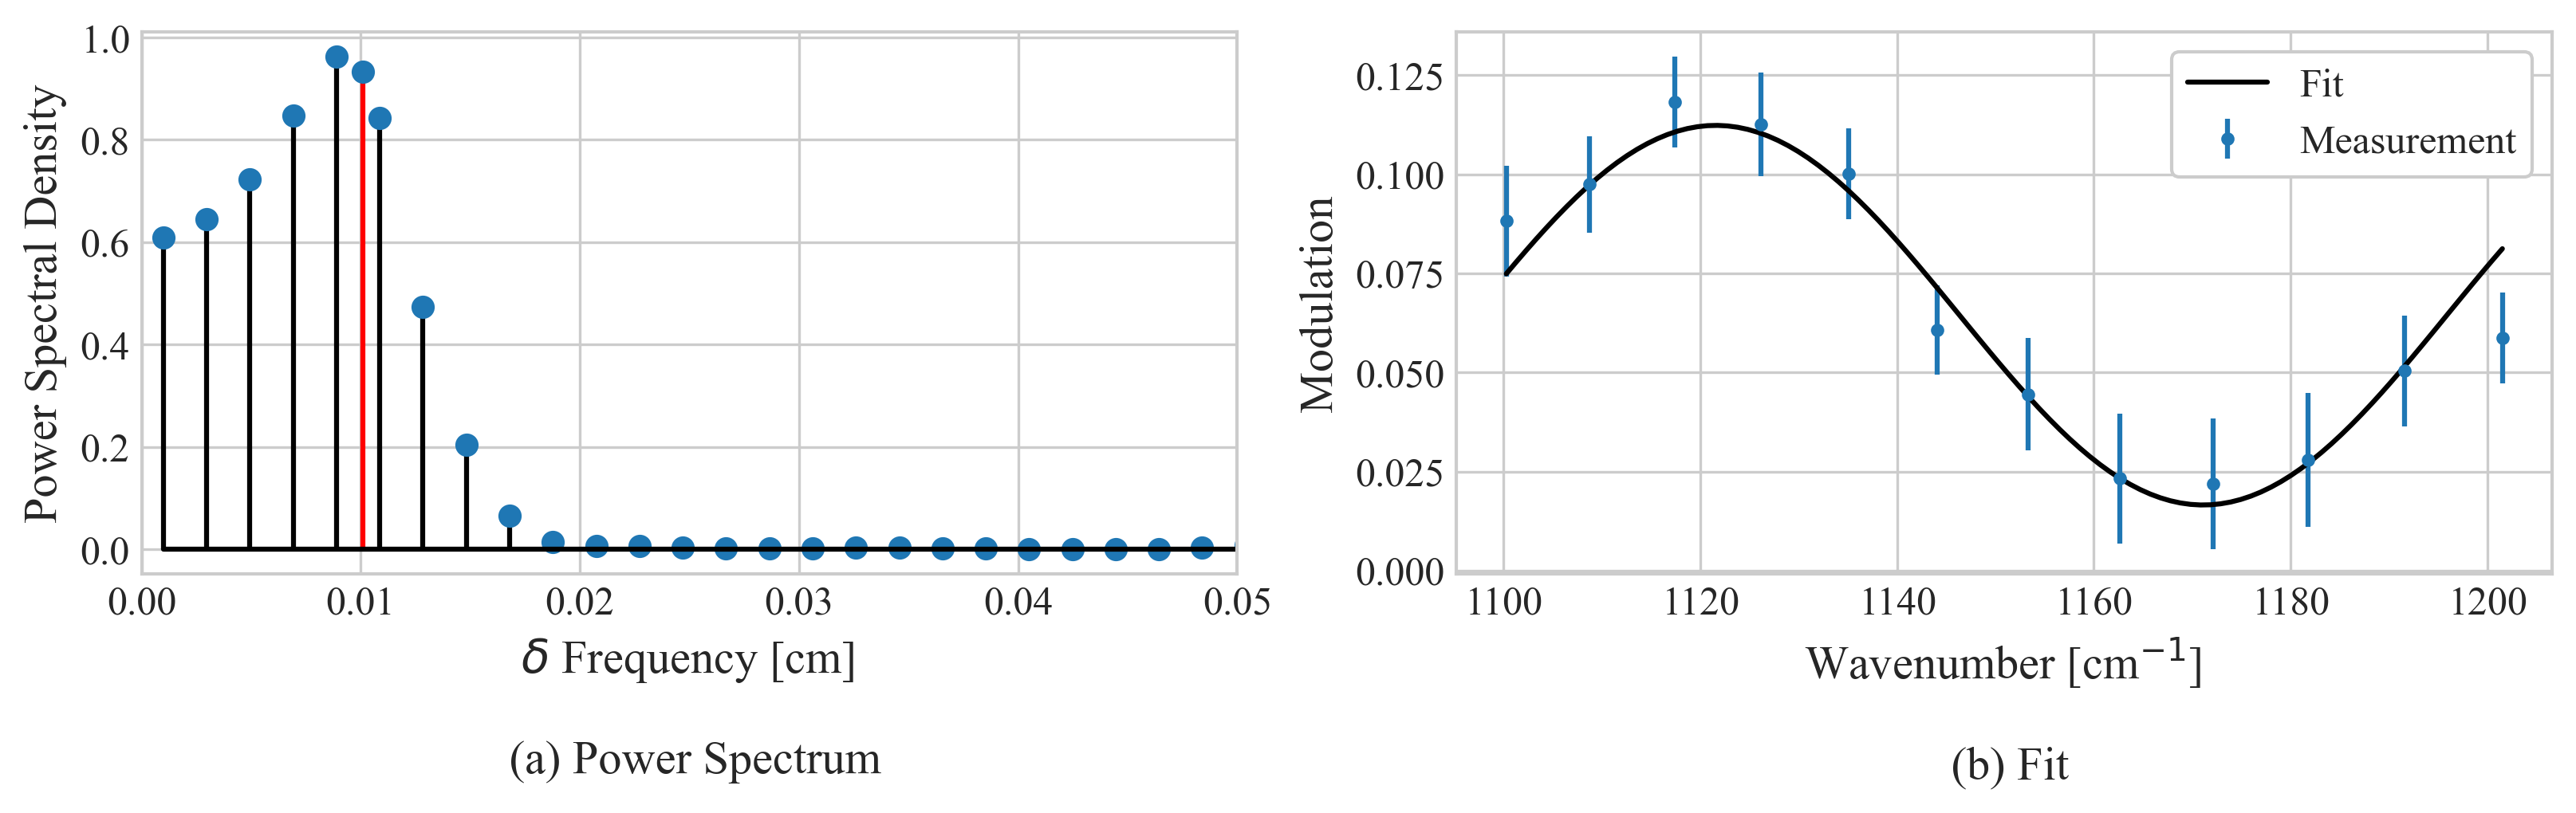

In [108]:
a = 90
j = 20
print('expected retardance ' + str(ret[j]))
start = pixel1[j] #first pixel 
stop  = pixel2[j] #last pixel 
n = stop-start;

x = wavnums[start:stop] #select mod period
data = calibration_mod[a] 
data_err = calibration_modE[a] 

y = data[start:stop]
dy = data_err[start:stop]
frequency = np.linspace(70,100,100)

ls = LombScargle(x, y)
frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5]) #sampling in 1 period intervalsLombScargle(x, y,dy)
frequency_full,power_full = LombScargle(x, y).autopower() #calculate the full power spectrum


best_frequency = frequency[np.argmax(power)]
t_fit = np.linspace(x[-1],x[0],100)
y_fit = ls.model(t_fit, best_frequency)

[offset,u,q] = ls.model_parameters( best_frequency)
print(best_frequency)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency_full, power_full, 'k',basefmt = 'k')
axes[0].stem(frequency, power, 'r',basefmt = 'k')
axes[0].set_xlim(0,.05)
axes[0].set_xlabel('$\delta$ Frequency [cm] \n \n (a) Power Spectrum')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit,'k', label='Fit')
axes[1].set_xlabel('Wavenumber [cm$^{-1}$] \n \n (b) Fit')
axes[1].set_ylabel('Modulation')
axes[1].errorbar(x,y,yerr = dy,fmt='.', label='Measurement')
legend = plt.legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [109]:
def LombFreq(j, data ):
    start = pixel1[j] #first pixel 
    stop  = pixel2[j] #last pixel 
    n = stop-start;

    x = wavnums[start:stop] #select mod period
    data = calibration_mod[a] 

    y = data[start:stop]
    dy = data_err
    frequency = np.linspace(70,100,100)

    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=ret[j+5],
                                              maximum_frequency=ret[j-5]) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[-1],x[0],1000)
    y_fit = ls.model(t_fit, best_frequency) #plot on a finer grid
    
    amplitude = (y_fit.max()-y_fit.min())/2
    
    return(best_frequency, amplitude)



Even though we've already corrected for wavelength dependent transmission which fixes the offset, the polarimetric efficiency will still vary with AoLP. Thus, the polarimetric eddiciency needs to be calculated as a function of AoLP

In [115]:
efficiency = []

for j in range(0,49):

    powers = np.zeros(360)
    freqs = np.zeros(360)

    for a in range(360):
        data = calibration_mod[a]
        try:
            f , pwr = LombFreq(j, data)
            powers[a] = pwr
            freqs[a] = f
        except:
            pass

    x = np.linspace(0,2*np.pi,len(angles)) #select mod period
    y = powers
    ls = LombScargle(x, y)
    frequency,power = LombScargle(x, y).autopower(minimum_frequency=.1,
                                                  maximum_frequency=2) #sampling in 1 period intervalsLombScargle(x, y,dy)

    best_frequency = frequency[np.argmax(power)]
    t_fit = np.linspace(x[0],x[-1],360)
    y_fit = ls.model(t_fit, best_frequency)
    efficiency.append(y_fit)

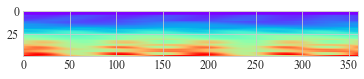

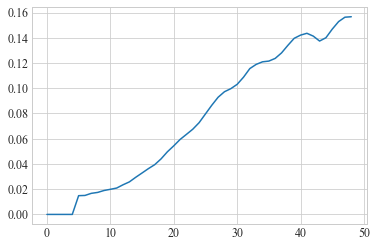

In [141]:
efficiency = np.array(efficiency)
plt.imshow(efficiency,cmap = 'rainbow')
plt.show()
eff_ang = t_fit

W = np.mean(efficiency,axis = 1)
plt.plot(W)

Fit apply over all AoLP to determine carrier freq

In [142]:
carrier = np.zeros(len(lambda_c))
for j in range(len(lambda_c)):
    freqs = np.zeros(360)
    for a in range(360):
        data = calibration_mod[a]
        try:
            f,p = LombFreq(j, data)
            freqs[a]= f
        except:
            freqs[a] = np.nan
    carrier[j] = np.median(freqs)

## Calculate the Phase Offset for Retrievel

In [144]:
def LombModel(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]
    Wq= W[j]
    Wu= W[j]

    x = wavnums[start:stop] #select mod period
    data = calibration_mod[a] 
    y = data[start:stop]
    dy = data_err
 

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        dolp = (((u)**2 +(q)**2)**0.5)
        aolp = 0.5*np.arctan2(u,q)
        if ((u)**2+(q)**2)**0.5 > 1:
            [prob,u,q] =[np.NAN,np.NAN,np.NAN]
            
    else:
        [prob,u,q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,aolp,q,u,prob])

In [145]:
results = np.zeros([len(waves),360,5])
for a in range(360):
    for j in range(5,49,1):

        results[j,a] = LombModel(a,j, 1)

calculate the offset

In [147]:
offset = []
results = np.zeros([len(lambda_c),360,5])
for j in range(len(lambda_c)):
    
    for a in range(0,360):
        try:
            results[j,a] = LombModel(a,j,1)  
        except:
            w =1  

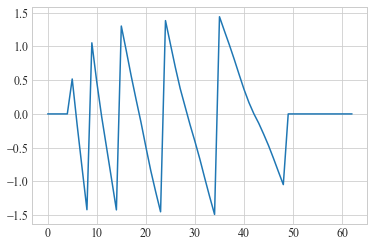

In [148]:
phase = results[:,0,1]
plt.plot(phase)

do retrieval and correct phase to determine aolp correction

In [149]:
j = 30
a = 0
[dolp,aolp,q,u,prob] = LombModel(a,j,1) 
aolp_corr = aolp - phase[j]
idx = find_nearest(eff_ang, aolp_corr )
eff = efficiency[j,idx]

1.0179829601483403

In [152]:
def LombModel_corr(a,j,thresh):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]
    Wq= W[j]
    Wu= W[j]

    x = wavnums[start:stop] #select mod period
    data = calibration_mod[a] 
    y = data[start:stop]
    dy = data_err
 

    ls = LombScargle(x, y)
    frequency, power = ls.autopower(minimum_frequency=carrier[j]-.002,
                                    maximum_frequency=carrier[j]+.002) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    best_frequency = frequency[np.argmax(power)]
    prob = ls.false_alarm_probability(power[np.argmax(power)])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        dolp = (((u)**2 +(q)**2)**0.5)
        aolp = 0.5*np.arctan2(u,q)
        if ((u)**2+(q)**2)**0.5 > 1:
            [prob,u,q] =[np.NAN,np.NAN,np.NAN]
            
    else:
        [prob,u,q,dolp,aolp] =[np.NAN,np.NAN,np.NAN,np.NAN,np.NAN]
    
    aolp_corr = aolp - phase[j]
    idx = find_nearest(eff_ang, aolp_corr )
    eff = efficiency[j,idx]
    dolp_corr = dolp/eff
    return([dolp_corr,aolp_corr,prob])

## Save Calibration File

In [180]:
hf = h5py.File(save_path + 'calibration.h5', 'w')
g = hf.create_group('polarization')
g.create_dataset('carrier',data= carrier)
g.create_dataset('W',data=efficiency)
g.create_dataset('W_ang',data=eff_ang)
g.create_dataset('phase',data=phase)
g.create_dataset('wavenums',data=wavnums)
hf.close()

# Radiometric Calibration

In [181]:
from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [182]:
#choose filepath to LUT calibration data calculated using pre-processing-Acktar
with h5py.File(path+ 'LUTdata.h5', "r") as file:
    waves = file['/waves'][()]
    temps = file['/temps'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    
    E1 = file['responses_err1'][()]
    E2 = file['responses_err2'][()]

array([25., 30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80.])

In [185]:
responses = R1+R2
responses1 = R1
responses2 = R2
responses_err = np.sqrt((E2/R2)**2+(E1/R1)**2)
responses_err1 = E1
responses_err2 = E2

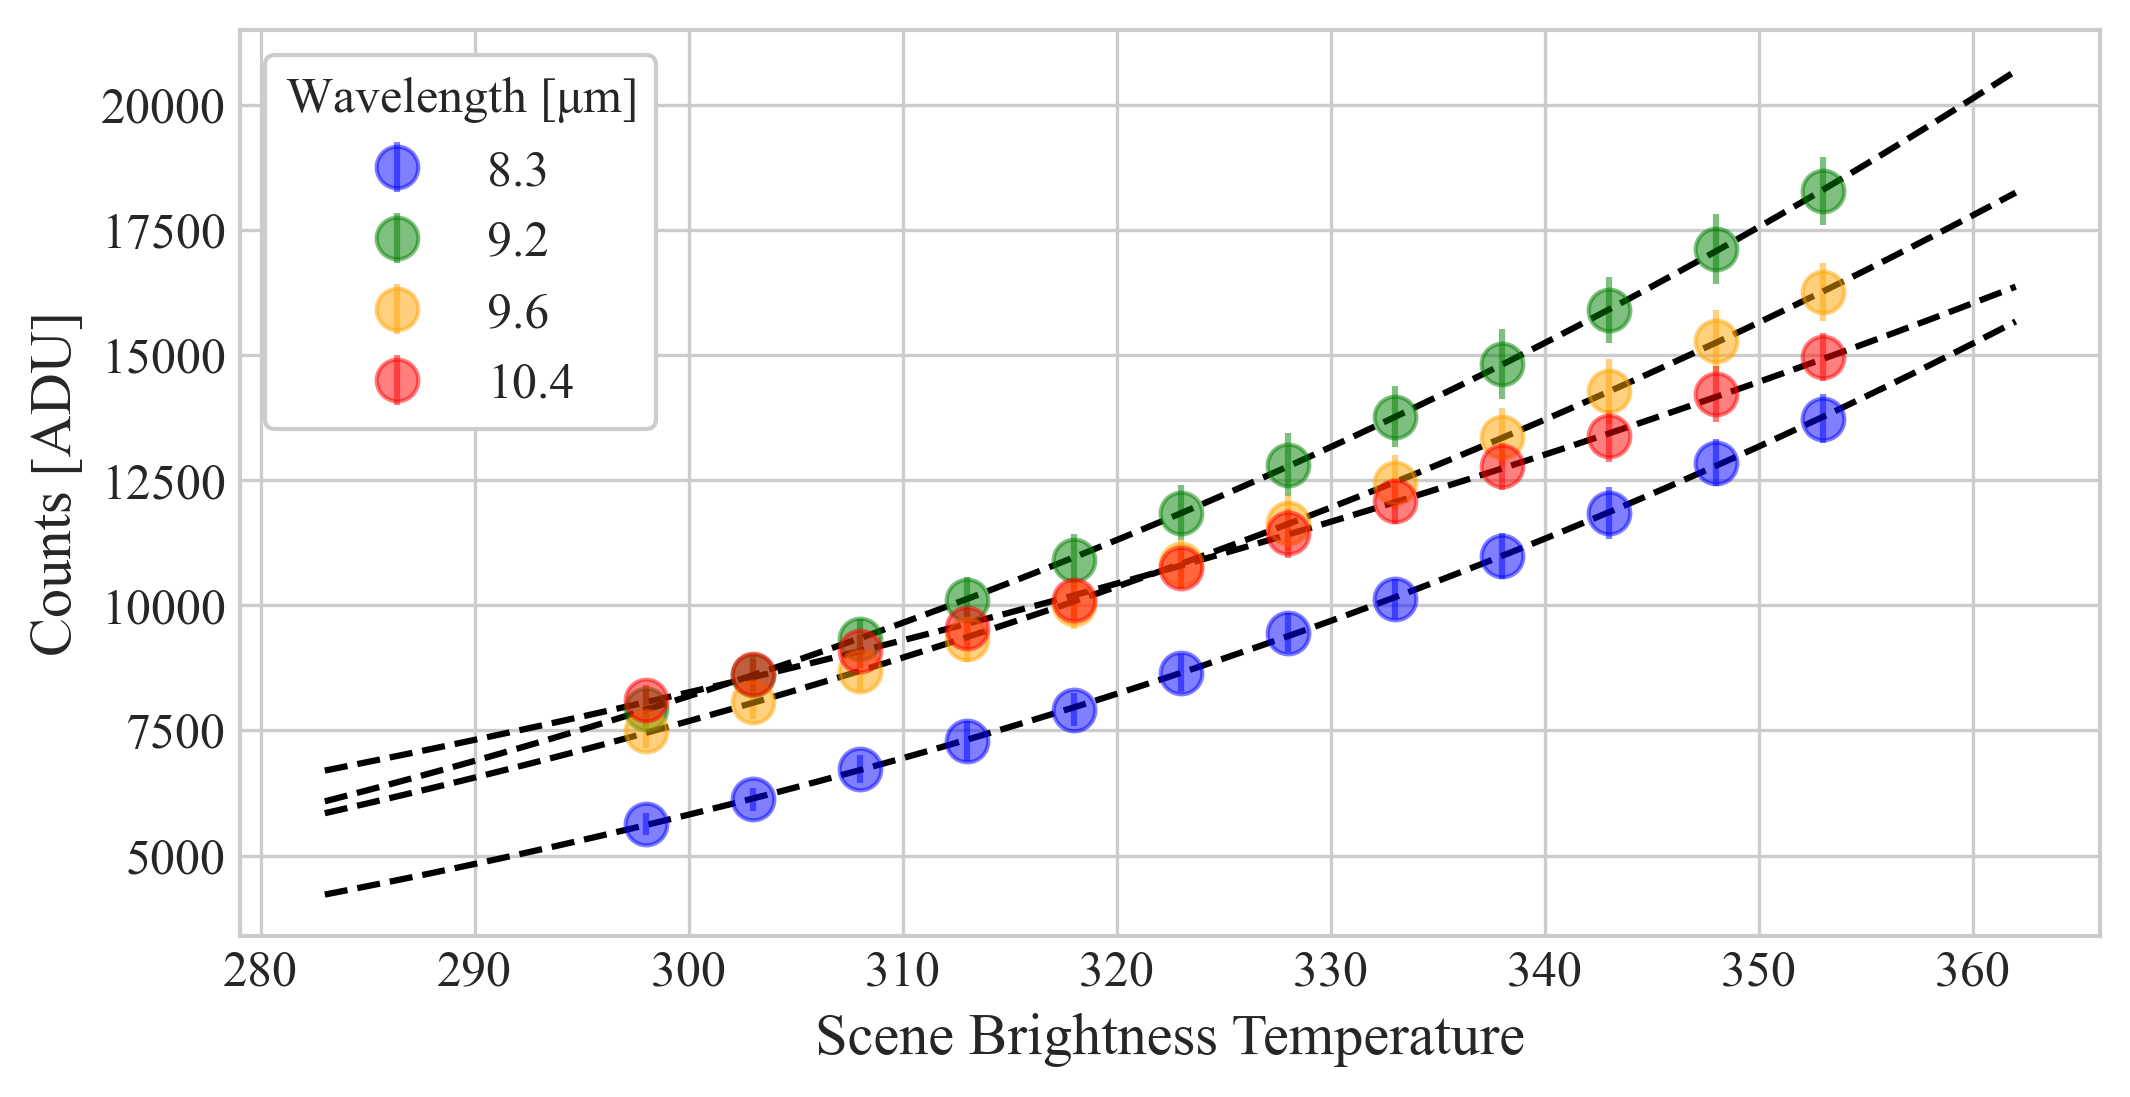

array([ 6.75044810e-07, -3.26197711e+01])

In [186]:
""" Fitting Function"""
def func(x, a, b):
    y = a*(x-b)**4 
    return y

colors = ['blue','green','orange','red']
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
nu =[14,26,32,44]
for i in range(4):
    ind = nu[i]
    start = pixel1[ind]
    stop  = pixel2[ind]

    x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)
    x2 = np.arange(10,90) + 273.15 #needs to be in kelvin

    popt, pcov = curve_fit(func, x, y, sigma = y_err)

    plt.plot(x2, func(x2, *popt), 'k--')
    plt.errorbar(x,y,yerr = y_err,fmt='.',color = colors[i],alpha=0.5,markersize = 20,label = str(np.round(lambda_c[ind],1)))

plt.xlabel("Scene Brightness Temperature")
plt.ylabel("Counts [ADU]")
legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

popt

In [192]:
var = np.zeros([36,2])
covar = np.zeros([36,2])

for ind in range(36):
    start = pixel1[ind]
    stop  = pixel2[ind]
    
    x = temps + 273.15
    y = np.sum(responses[:,start:stop],axis = 1)
    y_err = np.sum(responses_err[:,start:stop],axis = 1)

    popt, pcov = curve_fit(func, x, y, sigma = y_err)

    var[ind] = popt
    covar[ind] = np.sqrt(np.diag(pcov))

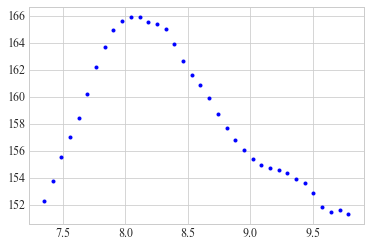

In [193]:
plt.errorbar(lambda_c[:36],var[:,1],yerr=covar[:,0],fmt = 'b.')
plt.show()

## Calculate NEDT

In [194]:
temp = np.linspace(-20,50,40) + 273.15
nedts = np.zeros([len(waves),len(temp)])
for i in range(36):
    for t in range(len(temp)):
        tem = temp[t]
        snr =  0
        delta = 0
        start = pixel1[i]
        stop  = pixel2[i]

        e = np.sum(responses_err[:,start:stop]/responses[:,start:stop])
        
        while snr < e:
            snr = np.abs(func(tem+delta/2,var[i,0],var[i,1])-func(tem-delta/2,var[i,0],var[i,1]))
            delta = delta +.001 

        nedts[i,t] = delta


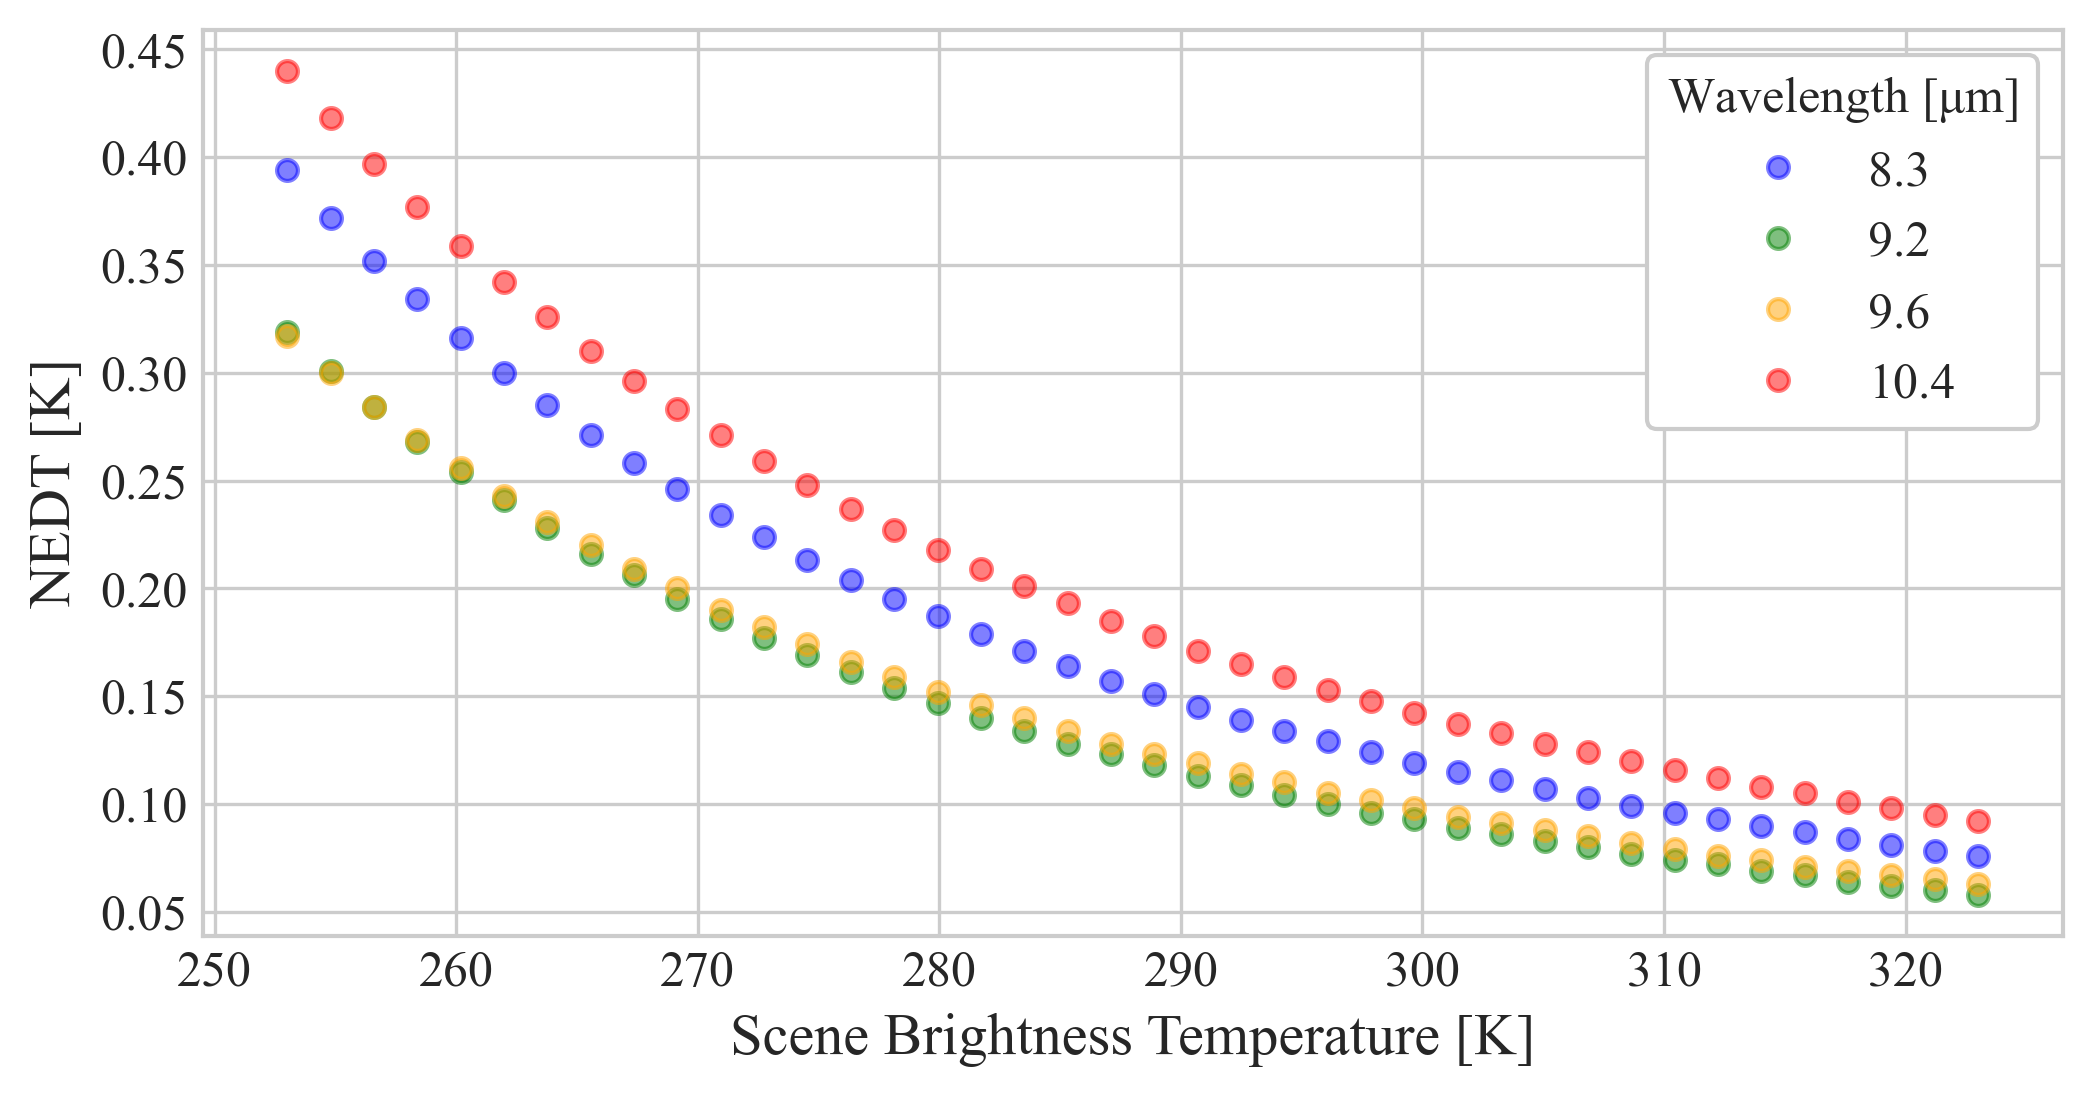

In [195]:
fig = plt.subplots(figsize = [8,4])
plt.gcf().set_dpi(300)
for i in range(4):
    ind = nu[i]
    plt.plot(temp,nedts[ind-10],'.',label = str(np.round(lambda_c[ind],1)), markersize = 10,color = colors[i],alpha = 0.5)
plt.legend( title='Wavelength [$\mathdefault{\mu}$m]')
plt.gcf().set_dpi(300)
plt.ylabel("NEDT [K]")
plt.xlabel("Scene Brightness Temperature [K]")

legend = plt.legend(title = 'Wavelength [$\mathdefault{\mu m}$]',framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
plt.show()

In [198]:
hf.close()
hf = h5py.File(save_path + 'calibration.h5', 'w')
g = hf.create_group('radiometric')
g.create_dataset('nedt',data= nedts)
g.create_dataset('var',data=var)
g.create_dataset('covar',data=covar)
hf.close()